### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle

import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy as sc
import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

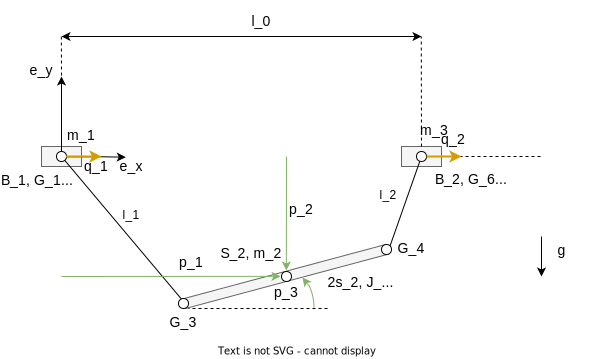

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

# define symbols for measured states
p_meas = st.symb_vector("pm1:{0}".format(3+1)) # error vector of passive coordinates
q_meas = st.symb_vector("qm1:{0}".format(2+1)) # error vector of actuated coordinates

meas_states = st.row_stack(p_meas, q_meas) ##:T
meas_states_d = st.time_deriv(meas_states, meas_states) ##:T

st.make_global(meas_states, meas_states_d)

# define symbols for reference trajectory states
p_ref = st.symb_vector("pr1:{0}".format(3+1)) # error vector of passive coordinates
q_ref = st.symb_vector("qr1:{0}".format(2+1)) # error vector of actuated coordinates

ref_states = st.row_stack(p_ref, q_ref)
ref_states_d = st.time_deriv(ref_states, ref_states)
ref_states_dd = st.time_deriv(ref_states, ref_states, order=2)
ref_states_ddd = st.time_deriv(ref_states, ref_states, order=3)
ref_states_dddd = st.time_deriv(ref_states, ref_states, order=4)

st.make_global(ref_states, ref_states_d, ref_states_dd, ref_states_ddd, ref_states_dddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

---

---

---

---

---

---

---

---

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")

Specify the geometry (joints G and centers of masses S)

---

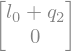

---

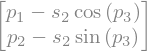

---

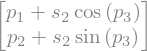

---

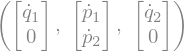

---

In [5]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# suspension points of load
G3 = S2 - Rz(p3)*ex*s2 ##:
G4 = S2 + Rz(p3)*ex*s2 ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

# rope vectors
rope1 = (G3 - S1)
rope2 = (G4 - S3)

# Initial values

In [6]:
# load model etc. from pickle of flatness analysis notebook
with open("flatness_analysis_control.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

In [7]:
# load model etc. from pickle of flatness analysis notebook
with open("qstat_expr.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

In [8]:
qstat_tau2.co

In [9]:
sys_params = list(dict(J2=0.004553475, g=9.81, l0=0.3, m1=0.45, m2=0.557, m3=0.45, s2=0.15).items()) ##:

sys_params := [('J2', 0.004553475),
 ('g', 9.81),
 ('l0', 0.3),
 ('m1', 0.45),
 ('m2', 0.557),
 ('m3', 0.45),
 ('s2', 0.15)]

---

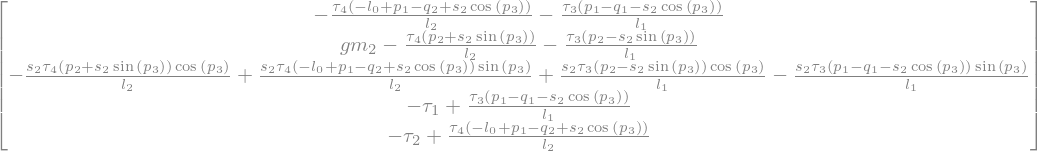

In [10]:
eqns.subz0(tthetadd)

---

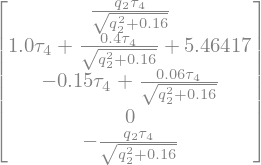

---

In [11]:
# determine a symetrical equilibrium:
# TODO: woher Wahl von ttau?
eqlbr_conditions = [(q1, 0), (p1, 0.15), (p2, -0.4), (p3, 0), (tau1, 0), (tau2, 0), (tau3, tau4)] ##:

res = ((mod.eqns.subz0(tthetadd)).subs(eqlbr_conditions)).subs(sys_params) ##:

In [12]:
symbs = list(res.s) ##:
sol = sp.solve(res, symbs, dict=True) ##:

---

---

In [13]:
ttheta0 = st.to_np(ttheta.subs(eqlbr_conditions).subs(sol[0])).squeeze() ##:

uu0 = st.to_np(ttau.subs(eqlbr_conditions).subs(sol[0])).squeeze()##:

ttheta0 := array([ 0.15, -0.4 ,  0.  ,  0.  ,  0.  ])

---

uu0 := array([ 0.      ,  0.      , -2.732085, -2.732085])

---

# Trajectory planning
The parametrization of $\tau_2$ determines the highest required order $N_i$ of the flat output's derivatives. For each component of the flat output a trajectory $y_i$ can be chosen with a polynomial order of $\alpha_i = 2 N_i + 1$ in compliance with the system's initial values.

---

---

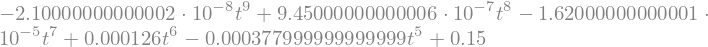

---

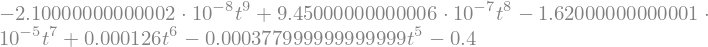

---

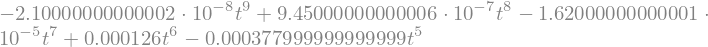

---

---

In [14]:
T0, T1 = 0, 10
p10, p20, p30, q10 = ttheta0[:-1] ##:
p1e, p2e, p3e, q1e = ttheta0[:-1] - 0.3 ##:
# p10 = p10 + 0.2
# p20 = p20 + 0.15
# q10 = q10 + 0.15
# p30 = p30 + 0.1
# polynoms of order 9 (boundary conditions until 4th derivative due to usage of qddot2 later) for p_i
p1_traj = st.condition_poly(t, (T0, p10, 0, 0, 0, 0), (T1, p1e, 0, 0, 0, 0)) ##:
p2_traj = st.condition_poly(t, (T0, p20, 0, 0, 0, 0), (T1, p2e, 0, 0, 0, 0)) ##:
p3_traj = st.condition_poly(t, (T0, p30, 0, 0, 0, 0), (T1, p3e, 0, 0, 0, 0)) ##:
# polynoms of order 5 (boundary conditions until 2nd derivative) for q_1
q1_traj = st.condition_poly(t, (T0, q10, 0, 0), (T1, q1e, 0, 0)) ##:
# trajectory for q2 from flatness relations 
q2_traj = flat_q2.subz([p1, p2, p3, pddot1, pddot2, pddot3, q1], [p1_traj, p2_traj, p3_traj, p1_traj.diff(t, 2), p2_traj.diff(t, 2), p3_traj.diff(t, 2), q1_traj])
q2_traj = q2_traj.subs(sys_params)

Substitution of $\mathbf{y}$ with trajectories into control inputs

In [15]:
flat_quantities = [pr1, pr2, pr3, qr1, qr2,
                   prdot1, prdot2, prdot3, qrdot1, qrdot2,
                   prddot1, prddot2, prddot3, qrddot1, qrddot2,
                   prdddot1, prdddot2, prdddot3, 
                   prddddot1, prddddot2, prddddot3]

flat_quant_subs = [p1_traj, p2_traj, p3_traj, q1_traj, q2_traj,
                   p1_traj.diff(t), p2_traj.diff(t), p3_traj.diff(t), q1_traj.diff(t), q2_traj.diff(t),
                   p1_traj.diff(t, 2), p2_traj.diff(t, 2), p3_traj.diff(t, 2), q1_traj.diff(t, 2), q2_traj.diff(t, 2),
                   p1_traj.diff(t, 3), p2_traj.diff(t, 3), p3_traj.diff(t, 3),
                   p1_traj.diff(t, 4), p2_traj.diff(t, 4), p3_traj.diff(t, 4)]

In [16]:
%%time

tau1_traj = flat_tau1_control.subz(flat_quantities, flat_quant_subs)
tau2_traj = flat_tau2_control.subz(flat_quantities, flat_quant_subs)
tau3_traj = flat_tau3_control.subz(flat_quantities, flat_quant_subs)
tau4_traj = flat_tau4_control.subz(flat_quantities, flat_quant_subs)

# verify that only constant system parameters, the time and measured quantities are included
set([*tau1_traj.s, *tau2_traj.s, *tau3_traj.s, *tau4_traj.s]) ##:

---

CPU times: user 23.1 s, sys: 2.08 ms, total: 23.1 s
Wall time: 23.2 s


In [17]:
tau1_traj_num = tau1_traj.subs(sys_params)
tau2_traj_num = tau2_traj.subs(sys_params)
tau3_traj_num = tau3_traj.subs(sys_params)
tau4_traj_num = tau4_traj.subs(sys_params)

In [18]:
tau1_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau1_traj_num)
tau2_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau2_traj_num)
tau3_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau3_traj_num)
tau4_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau4_traj_num)

In [19]:
# dito for reference trajectories for later plotting
p1_traj_func = st.expr_to_func(t, p1_traj)
p2_traj_func = st.expr_to_func(t, p2_traj)
p3_traj_func = st.expr_to_func(t, p3_traj)
q1_traj_func = st.expr_to_func(t, q1_traj)
q2_traj_func = st.expr_to_func(t, q2_traj)

# Simulation model

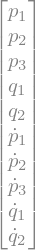

In [20]:
mod.xx

In [21]:
sim = st.SimulationModel(mod.f, mod.g, mod.xx, model_parameters=sys_params)

In [22]:
# control forces for stabilizing equilbrium
uu1 = uu0
def composite_force(x, t):
    # friction constants
    di = 10
    dissipation1 = -di*x[8]
    dissipation2 = -di*x[9]
    control_force = 0
    
    forces = uu1 #+ [dissipation1, dissipation2, 0.0, 0.0]
    return forces

# control forces for driving feed forward trajectories
def feed_forward_traj(x, t):
    if t < 1e-2:
        forces = uu1        
    elif t < 9.99:
        
        u1 = tau1_traj_func(t, *x)
        u2 = tau2_traj_func(t, *x)
        u3 = tau3_traj_func(t, *x)
        u4 = tau4_traj_func(t, *x)
        
        forces = [u1, u2, u3, u4]
    else:
        u1 = tau1_traj_func(9.99, *x)
        u2 = tau2_traj_func(9.99, *x)
        u3 = tau3_traj_func(9.99, *x)
        u4 = tau4_traj_func(9.99, *x)
        forces = [u1, u2, u3, u4]
    return forces

In [23]:
rhs = sim.create_simfunction(controller_function=feed_forward_traj)

In [24]:
xx0 = npy.concatenate((ttheta0, ttheta0*0)) ##:
#xx0 += npy.array([0.05, 0, 0, 0, 0,     0, 0, 0, 0, 0])
#xx0 += npy.array([0.1, -0.15, 0.15, 0.1, 0.05,     0, 0, 0, 0, 0])

xx0 := array([ 0.15, -0.4 ,  0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  ])

---

In [25]:
rhs(xx0, 0)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.24344979e-14,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [30]:
from sympy.utilities.autowrap import autowrap
from sympy import symbols, lambdify

def wraping(expression):
    return autowrap(expression, backend='cython')

tau1_traj_c = wraping(tau1_traj_num)
tau2_traj_c = wraping(tau2_traj_num)
tau3_traj_c = wraping(tau3_traj_num)
tau4_traj_c = wraping(tau4_traj_num)

In [27]:
tau1_traj_num.s

In [33]:
tau3_traj_num.s

In [32]:
tau4_traj_num.s

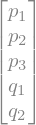

In [28]:
ttheta

In [73]:
%%timeit
binary_callable(xx0[1], xx0[2], xx0[6], xx0[7], xx0[3], xx0[8], 5)

34.6 µs ± 226 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [72]:
%%timeit
tau1_traj_func(5, *xx0)

521 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [45]:
# control inputs with c functions
def control_law_c(x, t):
    if t < 1e-2:
        forces = uu1        
    elif t < 9.99:
        
        u1 = tau1_traj_c(x[1], x[2], x[6], x[7], x[3], x[8], t)
        u2 = tau2_traj_c(x[1], x[2], x[6], x[7], x[4], x[9], t)
        u3 = tau3_traj_c(x[1], x[2], x[6], x[7], t)
        u4 = tau4_traj_c(x[1], x[2], x[6], x[7], t)
        
        forces = [u1, u2, u3, u4]
    else:
        u1 = tau1_traj_c(x[1], x[2], x[6], x[7], x[3], x[8], 9.99)
        u2 = tau2_traj_c(x[1], x[2], x[6], x[7], x[4], x[9], 9.99)
        u3 = tau3_traj_c(x[1], x[2], x[6], x[7], 9.99)
        u4 = tau4_traj_c(x[1], x[2], x[6], x[7], 9.99)
        forces = [u1, u2, u3, u4]
    return forces

In [46]:
rhs_c = sim.create_simfunction(controller_function=control_law_c)

In [35]:
#################################################

In [36]:
# error for initial state
def xx0_error():
 return npy.array([npy.random.uniform(-0.1,0.1), npy.random.uniform(-0.1,0.1), npy.random.uniform(-0.1,0.1), npy.random.uniform(-0.1,0.1), npy.random.uniform(-0.1,0.1),
                     0, 0, 0, 0, 0])

In [37]:
ensemble_size = 100

In [38]:
xx0_ensemble = []

for i in range(0,ensemble_size):
    xx0_ensemble = [*xx0_ensemble, xx0 + xx0_error()]

In [39]:
tt = npy.linspace(0, 20, 2000)

In [40]:
rhs(xx0, 0)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.24344979e-14,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [41]:
%%time
res_ensemble = []

for i in range(0,ensemble_size):
    res_i = sc_integrate.odeint(rhs, xx0_ensemble[i], tt)
    res_ensemble = [*res_ensemble, res_i]

CPU times: user 5min 9s, sys: 720 ms, total: 5min 10s
Wall time: 5min 8s


In [47]:
%%time
res_ensemble_c = []

for i in range(0,ensemble_size):
    res_i = sc_integrate.odeint(rhs_c, xx0_ensemble[i], tt)
    res_ensemble = [*res_ensemble_c, res_i]

CPU times: user 52.8 s, sys: 315 ms, total: 53.1 s
Wall time: 52.2 s


In [72]:
def theta_traj_func_continued(theta_func, times, len_continued):
    theta_before_end = theta_func(times) 
    theta_traj = npy.append(theta_before_end, theta_before_end[-1]*npy.ones(len_continued))
    return theta_traj

<Figure size 510.236x680.315 with 0 Axes>

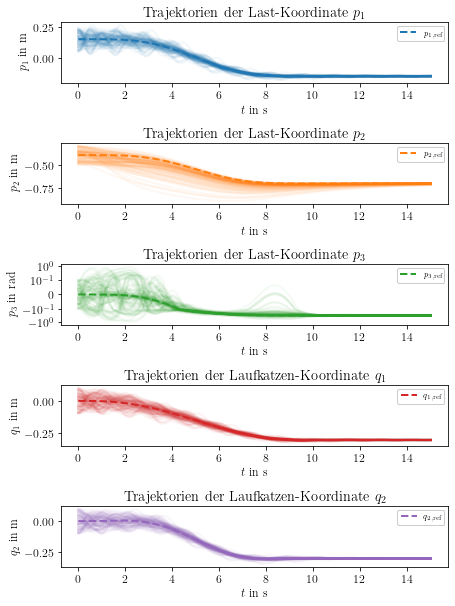

In [73]:
plt.rcParams['text.usetex'] = True  # LaTeX-aktivieren
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.subplot.bottom'] = .18
plt.rcParams['figure.subplot.left'] = .20
plt.rcParams['figure.subplot.top'] = .98
plt.rcParams['figure.subplot.right'] = .96
plt.rcParams['font.family'] = 'serif'

# Plot-Größe und Skalierungsfaktor
mm = 1./25.4  # mm to inch
scale = 1
fs = [180*mm*scale, 240*mm*scale]
fig1 = plt.figure(1, figsize=fs)


#plt.rcParams['figure.figsize'] = [25, 20]
fig, axs = plt.subplots(5, 1, figsize=fs)
plt.subplots_adjust(hspace = 1.0)

alpha_ensemble = 0.05

for i in range(0,ensemble_size):
    axs[0].plot(tt[:1500], res_ensemble[i][:1500, 0], '#1f77b4', linewidth=2.0, alpha=alpha_ensemble)
    axs[1].plot(tt[:1500], res_ensemble[i][:1500, 1], '#ff7f0e', linewidth=2.0, alpha=alpha_ensemble)
    axs[2].plot(tt[:1500], res_ensemble[i][:1500, 2], '#2ca02c', linewidth=2.0, alpha=alpha_ensemble)
axs[0].plot(tt[:1500], theta_traj_func_continued(p1_traj_func, tt[:1000], 500), '#1f77b4', linestyle='--', label=r'$p_{1,\mathrm{ref}}$', linewidth=2.0)
axs[1].plot(tt[:1500], theta_traj_func_continued(p2_traj_func, tt[:1000], 500), '#ff7f0e', linestyle='--', label=r'$p_{2,\mathrm{ref}}$', linewidth=2.0)
axs[2].plot(tt[:1500], theta_traj_func_continued(p3_traj_func, tt[:1000], 500), '#2ca02c', linestyle='--', label=r'$p_{3,\mathrm{ref}}$', linewidth=2.0)

for i in range(0,ensemble_size):
    axs[3].plot(tt[:1500], res_ensemble[i][:1500, 3], '#d62728', linewidth=2.0, alpha=alpha_ensemble)
    axs[4].plot(tt[:1500], res_ensemble[i][:1500, 4], '#9467bd', linewidth=2.0, alpha=alpha_ensemble)
axs[3].plot(tt[:1500], theta_traj_func_continued(q1_traj_func, tt[:1000], 500), '#d62728', linestyle='--', label=r'$q_{1,\mathrm{ref}}$', linewidth=2.0)
axs[4].plot(tt[:1500], theta_traj_func_continued(q2_traj_func, tt[:1000], 500), '#9467bd', linestyle='--', label=r'$q_{2,\mathrm{ref}}$', linewidth=2.0)

axs[0].legend(fancybox=True, framealpha=1.0)
axs[0].set_title('Trajektorien der Last-Koordinate $p_1$')
axs[0].set_xlabel(r'$t~\mathrm{in~s}$')
axs[0].set_ylabel('$p_1 ~ \mathrm{in~ m}$')
axs[1].legend(fancybox=True, framealpha=1.0)
axs[1].set_title('Trajektorien der Last-Koordinate $p_2$')
axs[1].set_xlabel(r'$t~\mathrm{in~s}$')
axs[1].set_ylabel('$p_2 ~ \mathrm{in~ m}$')
axs[2].legend(fancybox=True, framealpha=1.0)
axs[2].set_title('Trajektorien der Last-Koordinate $p_3$')
axs[2].set_xlabel(r'$t~\mathrm{in~s}$')
axs[2].set_ylabel('$p_3 ~ \mathrm{in~ rad}$')
axs[2].set_yscale("symlog", linthresh=1e-1)
axs[2].set_yticks([-1, -1e-1, 0, 1e-1, 1]) 
axs[3].legend(fancybox=True, framealpha=1.0)
axs[3].set_title('Trajektorien der Laufkatzen-Koordinate $q_1$')
axs[3].set_xlabel(r'$t~\mathrm{in~s}$')
axs[3].set_ylabel('$q_1  ~ \mathrm{in~ m}$')
axs[4].legend(fancybox=True, framealpha=1.0)
axs[4].set_title('Trajektorien der Laufkatzen-Koordinate $q_2$')
axs[4].set_xlabel(r'$t~\mathrm{in~s}$')
axs[4].set_ylabel('$q_2  ~ \mathrm{in~ m}$')

plt.savefig('feedforward_lin_selection_initial_error_ensemble.pdf', bbox_inches='tight')
plt.show()

<Figure size 510.236x340.157 with 0 Axes>

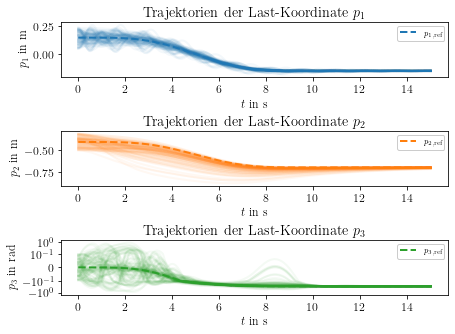

In [74]:
plt.rcParams['text.usetex'] = True  # LaTeX-aktivieren
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.subplot.bottom'] = .18
plt.rcParams['figure.subplot.left'] = .20
plt.rcParams['figure.subplot.top'] = .98
plt.rcParams['figure.subplot.right'] = .96
plt.rcParams['font.family'] = 'serif'

# Plot-Größe und Skalierungsfaktor
mm = 1./25.4  # mm to inch
scale = 1
fs = [180*mm*scale, 120*mm*scale]
fig1 = plt.figure(1, figsize=fs)


#plt.rcParams['figure.figsize'] = [25, 20]
fig, axs = plt.subplots(3, 1, figsize=fs)
plt.subplots_adjust(hspace = 1.0)

alpha_ensemble = 0.05

for i in range(0,ensemble_size):
    axs[0].plot(tt[:1500], res_ensemble[i][:1500, 0], '#1f77b4', linewidth=2.0, alpha=alpha_ensemble)
    axs[1].plot(tt[:1500], res_ensemble[i][:1500, 1], '#ff7f0e', linewidth=2.0, alpha=alpha_ensemble)
    axs[2].plot(tt[:1500], res_ensemble[i][:1500, 2], '#2ca02c', linewidth=2.0, alpha=alpha_ensemble)
axs[0].plot(tt[:1500], theta_traj_func_continued(p1_traj_func, tt[:1000], 500), '#1f77b4', linestyle='--', label=r'$p_{1,\mathrm{ref}}$', linewidth=2.0)
axs[1].plot(tt[:1500], theta_traj_func_continued(p2_traj_func, tt[:1000], 500), '#ff7f0e', linestyle='--', label=r'$p_{2,\mathrm{ref}}$', linewidth=2.0)
axs[2].plot(tt[:1500], theta_traj_func_continued(p3_traj_func, tt[:1000], 500), '#2ca02c', linestyle='--', label=r'$p_{3,\mathrm{ref}}$', linewidth=2.0)

axs[0].legend(fancybox=True, framealpha=1.0)
axs[0].set_title('Trajektorien der Last-Koordinate $p_1$')
axs[0].set_xlabel(r'$t~\mathrm{in~s}$')
axs[0].set_ylabel('$p_1 ~ \mathrm{in~ m}$')
axs[1].legend(fancybox=True, framealpha=1.0)
axs[1].set_title('Trajektorien der Last-Koordinate $p_2$')
axs[1].set_xlabel(r'$t~\mathrm{in~s}$')
axs[1].set_ylabel('$p_2 ~ \mathrm{in~ m}$')
axs[2].legend(fancybox=True, framealpha=1.0)
axs[2].set_title('Trajektorien der Last-Koordinate $p_3$')
axs[2].set_xlabel(r'$t~\mathrm{in~s}$')
axs[2].set_ylabel('$p_3 ~ \mathrm{in~ rad}$')
axs[2].set_yscale("symlog", linthresh=1e-1)
axs[2].set_yticks([-1, -1e-1, 0, 1e-1, 1]) 

plt.savefig('feedforward_lin_selection_initial_error_ensemble_flat_output.pdf', bbox_inches='tight')
plt.show()

<Figure size 510.236x283.465 with 0 Axes>

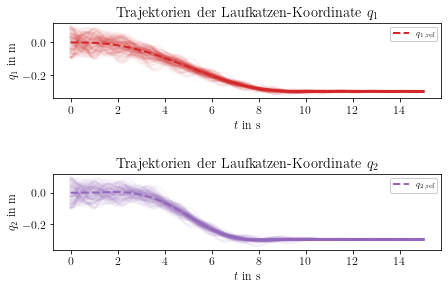

In [75]:
plt.rcParams['text.usetex'] = True  # LaTeX-aktivieren
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.subplot.bottom'] = .18
plt.rcParams['figure.subplot.left'] = .20
plt.rcParams['figure.subplot.top'] = .98
plt.rcParams['figure.subplot.right'] = .96
plt.rcParams['font.family'] = 'serif'

# Plot-Größe und Skalierungsfaktor
mm = 1./25.4  # mm to inch
scale = 1
fs = [180*mm*scale, 100*mm*scale]
fig1 = plt.figure(1, figsize=fs)


#plt.rcParams['figure.figsize'] = [25, 20]
fig, axs = plt.subplots(2, 1, figsize=fs)
plt.subplots_adjust(hspace = 1.0)

alpha_ensemble = 0.05

for i in range(0,ensemble_size):
    axs[0].plot(tt[:1500], res_ensemble[i][:1500, 3], '#d62728', linewidth=2.0, alpha=alpha_ensemble)
    axs[1].plot(tt[:1500], res_ensemble[i][:1500, 4], '#9467bd', linewidth=2.0, alpha=alpha_ensemble)
axs[0].plot(tt[:1500], theta_traj_func_continued(q1_traj_func, tt[:1000], 500), '#d62728', linestyle='--', label=r'$q_{1,\mathrm{ref}}$', linewidth=2.0)
axs[1].plot(tt[:1500], theta_traj_func_continued(q2_traj_func, tt[:1000], 500), '#9467bd', linestyle='--', label=r'$q_{2,\mathrm{ref}}$', linewidth=2.0)

axs[0].legend(fancybox=True, framealpha=1.0)
axs[0].set_title('Trajektorien der Laufkatzen-Koordinate $q_1$')
axs[0].set_xlabel(r'$t~\mathrm{in~s}$')
axs[0].set_ylabel('$q_1  ~ \mathrm{in~ m}$')
axs[1].legend(fancybox=True, framealpha=1.0)
axs[1].set_title('Trajektorien der Laufkatzen-Koordinate $q_2$')
axs[1].set_xlabel(r'$t~\mathrm{in~s}$')
axs[1].set_ylabel('$q_2  ~ \mathrm{in~ m}$')

plt.savefig('feedforward_lin_selection_initial_error_ensemble_flat_output_q.pdf', bbox_inches='tight')
plt.show()

In [76]:
#################################################

In [77]:
# numeric trajs
p1_num = st.expr_to_func(t, p1_traj)
p2_num = st.expr_to_func(t, p2_traj)
p3_num = st.expr_to_func(t, p3_traj)
q1_num = st.expr_to_func(t, q1_traj)
q2_num = st.expr_to_func(t, q2_traj)
pdot1_num = st.expr_to_func(t, p1_traj.diff(t))
pdot2_num = st.expr_to_func(t, p2_traj.diff(t))
pdot3_num = st.expr_to_func(t, p3_traj.diff(t))
qdot1_num = st.expr_to_func(t, q1_traj.diff(t))
qdot2_num = st.expr_to_func(t, q2_traj.diff(t))
# deviation of simulated and reference trajs
err_trajp1 = res[:1000, 0] - p1_num(tt[tt<10])
err_trajp2 = res[:1000, 1] - p2_num(tt[tt<10]) 
err_trajp3 = res[:1000, 2] - p3_num(tt[tt<10]) 
err_trajq1 = res[:1000, 3] - q1_num(tt[tt<10]) 
err_trajq2 = res[:1000, 4] - q2_num(tt[tt<10])
err_trajpdot1 = res[:1000, 5] - pdot1_num(tt[tt<10])
err_trajpdot2 = res[:1000, 6] - pdot2_num(tt[tt<10]) 
err_trajpdot3 = res[:1000, 7] - pdot3_num(tt[tt<10]) 
err_trajqdot1 = res[:1000, 8] - qdot1_num(tt[tt<10])
err_trajqdot2 = res[:1000, 9] - qdot2_num(tt[tt<10]) 
# ... mean
mean_err_trajp1 = npy.mean(abs(err_trajp1)) ##:
mean_err_trajp2 = npy.mean(abs(err_trajp2)) ##:
mean_err_trajp3 = npy.mean(abs(err_trajp3)) ##:
mean_err_trajq1 = npy.mean(abs(err_trajq1)) ##:
mean_err_trajq2 = npy.mean(abs(err_trajq2)) ##:

ShapeError: Matrix size mismatch: (5, 1) + (1000,)

In [82]:
# stationary difference:
inf_err_trajp1 = abs(res[1500, 0] - p1_num(10)) ##:
inf_err_trajp2 = abs(res[1500, 1] - p2_num(10)) ##:
inf_err_trajp3 = abs(res[1500, 2] - p3_num(10)) ##:
inf_err_trajq1 = abs(res[1500, 3] - q1_num(10)) ##:

IndexError: Index out of range: a[1500]

In [84]:
ttau = list(map(feed_forward_traj, res[1:1500, :] ,tt[1:1500]))
ttau1, ttau2, ttau3, ttau4 = zip(*ttau)

TypeError: func2() argument after * must be an iterable, not Add

In [85]:
plt.plot(tt[1:1500], ttau1, label="tau1")
plt.plot(tt[1:1500], ttau2, label="tau2")
plt.plot(tt[1:1500], ttau3, label="tau3")
plt.plot(tt[1:1500], ttau4, label="tau4")
plt.legend()

NameError: name 'ttau1' is not defined

In [86]:
######## feedforward tau for reference

In [87]:
xx0true = npy.array([*ttheta0, *ttheta0*0])
res_ref = sc_integrate.odeint(rhs, xx0true, tt) ##:i
ttau_ref = list(map(feed_forward_traj, res_ref[1:1500, :] ,tt[1:1500]))
ttau1_ref, ttau2_ref, ttau3_ref, ttau4_ref = zip(*ttau_ref)

info(res_ref) := "<class 'numpy.ndarray'> with shape: (2000, 10)"

---

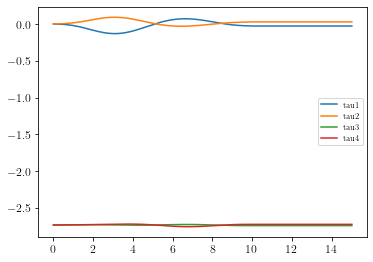

In [88]:
plt.plot(tt[1:1500], ttau1_ref, label="tau1")
plt.plot(tt[1:1500], ttau2_ref, label="tau2")
plt.plot(tt[1:1500], ttau3_ref, label="tau3")
plt.plot(tt[1:1500], ttau4_ref, label="tau4")
plt.legend()

In [89]:
########################

ValueError: x and y must have same first dimension, but have shapes (1500,) and (5, 1)

<Figure size 510.236x680.315 with 0 Axes>

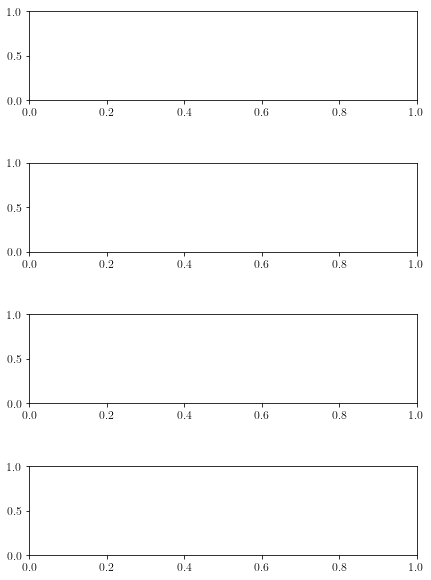

In [90]:
plt.rcParams['text.usetex'] = True  # LaTeX-aktivieren
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.subplot.bottom'] = .18
plt.rcParams['figure.subplot.left'] = .20
plt.rcParams['figure.subplot.top'] = .98
plt.rcParams['figure.subplot.right'] = .96
plt.rcParams['font.family'] = 'serif'

# Plot-Größe und Skalierungsfaktor
mm = 1./25.4  # mm to inch
scale = 1
fs = [180*mm*scale, 240*mm*scale]
fig1 = plt.figure(1, figsize=fs)


#plt.rcParams['figure.figsize'] = [25, 20]
fig, axs = plt.subplots(4, 1, figsize=fs)
plt.subplots_adjust(hspace = .7)

axs[0].plot(tt[:1500], res[:1500, 0], '#1f77b4', label=r'$p_{1}$', linewidth=2.0)
axs[0].plot(tt[:1500], res[:1500, 1], '#ff7f0e', label=r'$p_{2}$', linewidth=2.0)
axs[0].plot(tt[:1500], res[:1500, 2], '#2ca02c', label=r'$p_{3}$', linewidth=2.0)
axs[0].plot(tt[:1000], p1_traj_func(tt[:1000]), '#1f77b4', linestyle='--', label=r'$p_{1,\mathrm{ref}}$', linewidth=2.0)
axs[0].plot(tt[:1000], p2_traj_func(tt[:1000]), '#ff7f0e', linestyle='--', label=r'$p_{2,\mathrm{ref}}$', linewidth=2.0)
axs[0].plot(tt[:1000], p3_traj_func(tt[:1000]), '#2ca02c', linestyle='--', label=r'$p_{3,\mathrm{ref}}$', linewidth=2.0)

axs[0].legend(fancybox=True, framealpha=1.0)
axs[0].set_title('Trajektorien der Last-Koordinaten')
axs[0].set_xlabel(r'$t~\mathrm{in~s}$')
axs[0].set_ylabel('$p_i ~ \mathrm{in~ m}$')

axs[1].plot(tt[:1500], res[:1500, 3], '#d62728', label=r'$q_{1}$', linewidth=2.0)
axs[1].plot(tt[:1500], res[:1500, 4], '#9467bd', label=r'$q_{2}$', linewidth=2.0)
axs[1].plot(tt[:1000], q1_traj_func(tt[:1000]), '#d62728', linestyle='--', label=r'$q_{1,\mathrm{ref}}$', linewidth=2.0)
axs[1].plot(tt[:1000], q2_traj_func(tt[:1000]), '#9467bd', linestyle='--', label=r'$q_{2,\mathrm{ref}}$', linewidth=2.0)

axs[1].legend(fancybox=True, framealpha=1.0)
axs[1].set_title('Trajektorien der Laufkatzen-Koordinaten')
axs[1].set_xlabel(r'$t~\mathrm{in~s}$')
axs[1].set_ylabel('$q_i  ~ \mathrm{in~ m}$')

'''
axs[2].plot(tt[1:1500], ttau1, '#1f77b4', label=r'$\tau_{1}$', linewidth=2.0)
axs[2].plot(tt[1:1500], ttau2, '#ff7f0e', label=r'$\tau_{2}$', linewidth=2.0)
axs[2].plot(tt[1:1500], ttau3, '#2ca02c', label=r'$\tau_{3}$', linewidth=2.0)
axs[2].plot(tt[1:1500], ttau4, '#d62728', label=r'$\tau_{4}$', linewidth=2.0)

axs[2].legend(fancybox=True, framealpha=1.0)
axs[2].set_title('Trajektorien der Eingangsgrößen')
axs[2].set_xlabel(r'$t~\mathrm{in~s}$')
axs[2].set_ylabel(r'$\tau_{i}  ~ \mathrm{in~ N}$')
'''

axs[2].plot(tt[1:1500], ttau1, '#1f77b4', label=r'$\tau_{1}$', linewidth=2.0)
axs[2].plot(tt[1:1500], ttau2, '#d62728', label=r'$\tau_{2}$', linewidth=2.0)
axs[2].plot(tt[1:1500], ttau1_ref, '#1f77b4', linestyle='--', label=r'$\tau_{1,\mathrm{ref}}$', linewidth=2.0)
axs[2].plot(tt[1:1500], ttau2_ref, '#d62728', linestyle='--', label=r'$\tau_{2,\mathrm{ref}}$', linewidth=2.0)

axs[2].legend(fancybox=True, framealpha=1.0, loc="lower right")
axs[2].set_title('Trajektorien der Katzfahrteingänge')
axs[2].set_xlabel(r'$t~\mathrm{in~s}$')
axs[2].set_ylabel(r'$\tau_{1},~\tau_{2}  ~ \mathrm{in~ N}$')

axs[3].plot(tt[1:1500], ttau3, '#ff7f0e', label=r'$\tau_{3}$', linewidth=2.0)
axs[3].plot(tt[1:1500], ttau4, '#2ca02c', label=r'$\tau_{4}$', linewidth=2.0)
axs[3].plot(tt[1:1500], ttau3_ref, '#ff7f0e', linestyle='--', label=r'$\tau_{3,\mathrm{ref}}$', linewidth=2.0)
axs[3].plot(tt[1:1500], ttau4_ref, '#2ca02c', linestyle='--', label=r'$\tau_{4,\mathrm{ref}}$', linewidth=2.0)

axs[3].legend(fancybox=True, framealpha=1.0, loc="lower right")
axs[3].set_title('Trajektorien der Hubfahrteingänge')
axs[3].set_xlabel(r'$t~\mathrm{in~s}$')
axs[3].set_ylabel(r'$\tau_{3},~\tau_{4}  ~ \mathrm{in~ N}$')

plt.savefig('feedforward_lin_pseudo_controller_initial_error.pdf', bbox_inches='tight')
plt.show()

### Stability analysis of current trajectories

In [84]:
xref, error, errord = sp.symbols('x_{ref} e_x \dot{e}_x')

In [85]:
eetheta = st.symb_vector("e1:{0}".format(len(ttheta)+1)) ##:T
eethetad = st.time_deriv(eetheta, eetheta, order=1) ##:T 
eethetadd = st.time_deriv(eetheta, eetheta, order=2) ##:T 

xxref = st.row_stack(ref_states, ref_states_d) ##:T
xxrefd = st.row_stack(ref_states_d, ref_states_dd) ##:T
eerror = st.row_stack(eetheta, eethetad) ##:T
eerrord = st.row_stack(eethetad, eethetadd) ##:T

st.make_global(xxref, xxrefd, eerror, eerrord)

---

---

---

---

---

---

---

In [129]:
# place current controller functions here:
tau_control = sp.Matrix([flat_tau1_control, flat_tau2_control, flat_tau3_control, flat_tau4_control])
tau_control = tau_control.subz([*tthetadd, *tthetad, *ttheta], [*ref_states_dd, *ref_states_d, *ref_states])

In [130]:
xx = eerror + xxref
ffex = mod.f.subz([*ttheta, *tthetad], [*xx]).smplf + mod.g.subz([*ttheta, *tthetad], [*xx]).smplf * tau_control.subz([*meas_states, *meas_states_d], [*xx]) - xxrefd

In [131]:
P = sp.eye(10)
Vdot = (xx.T * P * ffex)[0] ## = w(ex, t)

In [132]:
ffex0 = ffex.subz0(eerror)

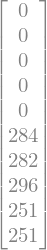

In [133]:
ffex0.co

In [134]:
jacobi = ffex.jacobian(eerror)
jacobi0 = jacobi.subz0(eerror)

---

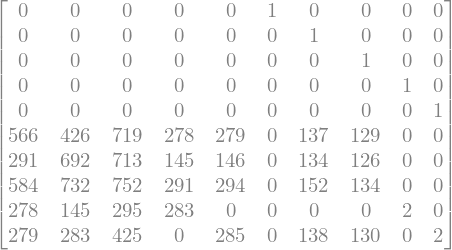

---

In [135]:
jacobi0.s ##:
jacobi0.co ##:

In [136]:
hesse = sp.hessian(Vdot, eerror)
hesse0 = hesse.subz0(eerror)

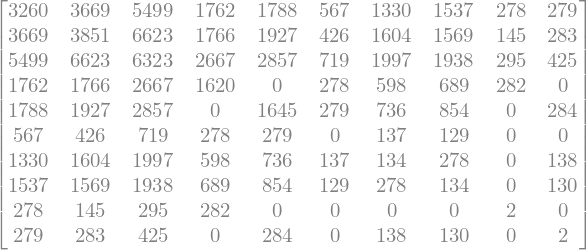

In [137]:
hesse0.co

First look if error dynamics is 0 for equilibrium in $t = 0, 10$

In [138]:
flat_quantities_wr = [ pr1, pr2, pr3, qr1, qr2,
                       prdot1, prdot2, prdot3, qrdot1, qrdot2,
                       prddot1, prddot2, prddot3, qrddot1, qrddot2,
                       prdddot1, prdddot2, prdddot3, 
                       prddddot1, prddddot2, prddddot3]

In [139]:
ffex0_num = ffex0.subs(sys_params)
ffex0_num = ffex0_num.subz(flat_quantities_wr, flat_quant_subs)

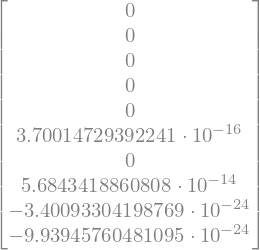

---

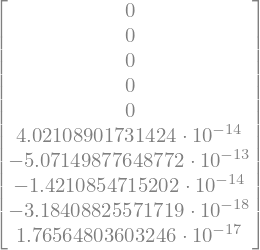

---

In [140]:
ffex0_num_t0 = ffex0_num.subs(t, 0.01) 
ffex0_num_t0 ##:
ffex0_num_t10 = ffex0_num.subs(t, 10)
ffex0_num_t10 ##:

#### Lyapunov's indirect (1st) method

In [141]:
jacobi_num = jacobi0.subs(sys_params)
#jacobi_num = jacobi_num.subz(flat_quantities, flat_quant_subs)

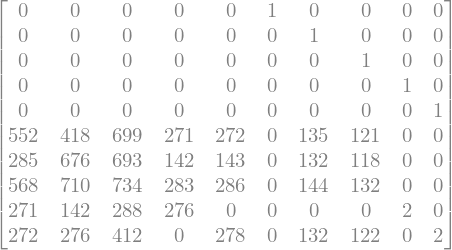

In [142]:
jacobi_num.co

In [143]:
tti = npy.arange(0.1, 10.1, 0.1)
eigs = []

In [144]:
for ti in tti:
    flat_quant_subs_num = [flats.subs(t, ti) for flats in flat_quant_subs]
    jacobi_num_ti = jacobi_num.subz(flat_quantities_wr, flat_quant_subs_num)
    jacobi_num_ti_eigs = npy.linalg.eig(st.to_np(jacobi_num_ti))
    eigs.append(jacobi_num_ti_eigs[0].real)

In [145]:
eigs

[array([-0.37939454, -0.37939454, -0.62060546, -0.62060546, -1.        , -1.        , -1.        , -1.        , -0.99999996, -1.00000004]),
 array([-0.37939452, -0.37939452, -0.62060548, -0.62060548, -1.        , -1.        , -1.        , -1.        , -1.        , -1.        ]),
 array([-0.37939449, -0.37939449, -1.        , -1.        , -0.62060551, -0.62060551, -1.        , -1.        , -1.00000006, -0.99999994]),
 array([-0.37939447, -0.37939447, -1.        , -1.        , -0.62060554, -0.62060554, -1.        , -1.        , -1.        , -1.        ]),
 array([-0.37939451, -0.37939451, -1.        , -1.        , -0.62060553, -0.62060553, -0.99999996, -0.99999996, -1.        , -1.        ]),
 array([-0.37939475, -0.37939475, -1.        , -1.        , -0.62060551, -0.62060551, -0.99999974, -0.99999974, -1.        , -1.        ]),
 array([-0.37939544, -0.37939544, -1.        , -1.        , -0.62060569, -0.62060569, -0.99999887, -0.99999887, -1.00000007, -0.99999993]),
 array([-0.37939695,

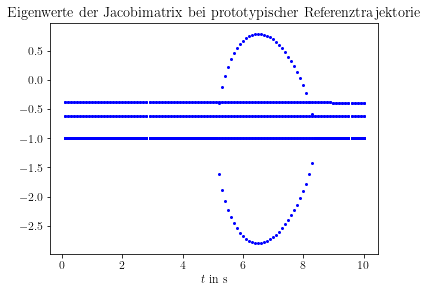

In [147]:
plt.clf() 

plt.rcParams['text.usetex'] = True  # LaTeX-aktivieren
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.subplot.bottom'] = .18
plt.rcParams['figure.subplot.left'] = .20
plt.rcParams['figure.subplot.top'] = .98
plt.rcParams['figure.subplot.right'] = .96
plt.rcParams['font.family'] = 'serif'

# Plot-Größe und Skalierungsfaktor
mm = 1./25.4  # mm to inch
scale = 1
fs = [78*mm*scale, 60*mm*scale]
fig1 = plt.figure(1, figsize=fs)

plt.title('Eigenwerte der Jacobimatrix bei prototypischer Referenztrajektorie')
plt.xlabel(r'$t~\mathrm{in~s}$')

plt.plot(tti, eigs, 'bo', markersize=2.0)

plt.savefig('feedforward_lin_selec_ljapunov1.pdf', bbox_inches='tight')
plt.show()

#### Lyapunov's direct (2nd) method

In [82]:
# load with pickle
#pickle_data = {"Vdot":Vdot, "Vdot_traj":Vdot_traj, "Vdot_traj_num":Vdot_traj_num, "hesse": hesse, "hesse0": hesse0}

load_hesse = 1

if load_hesse == 1:
    with open("hesse_matrix.pcl", "rb") as pfile:
        data = pickle.load(pfile)
        locals().update(data)

else:
    Vdot_traj = Vdot.subz(flat_quantities, flat_quant_subs)
    Vdot_traj_num = Vdot_traj.subs(sys_params)
    hesse = sp.hessian(Vdot_traj_num, eerror)
    hesse0 = hesse.subz0(eerror)

In [83]:
Vdot0 = Vdot_traj_num.subz0(eerror)

In [84]:
Vdot0i = []

for ti in tti:
    Vdot0i.append(Vdot0.subs(t, ti))

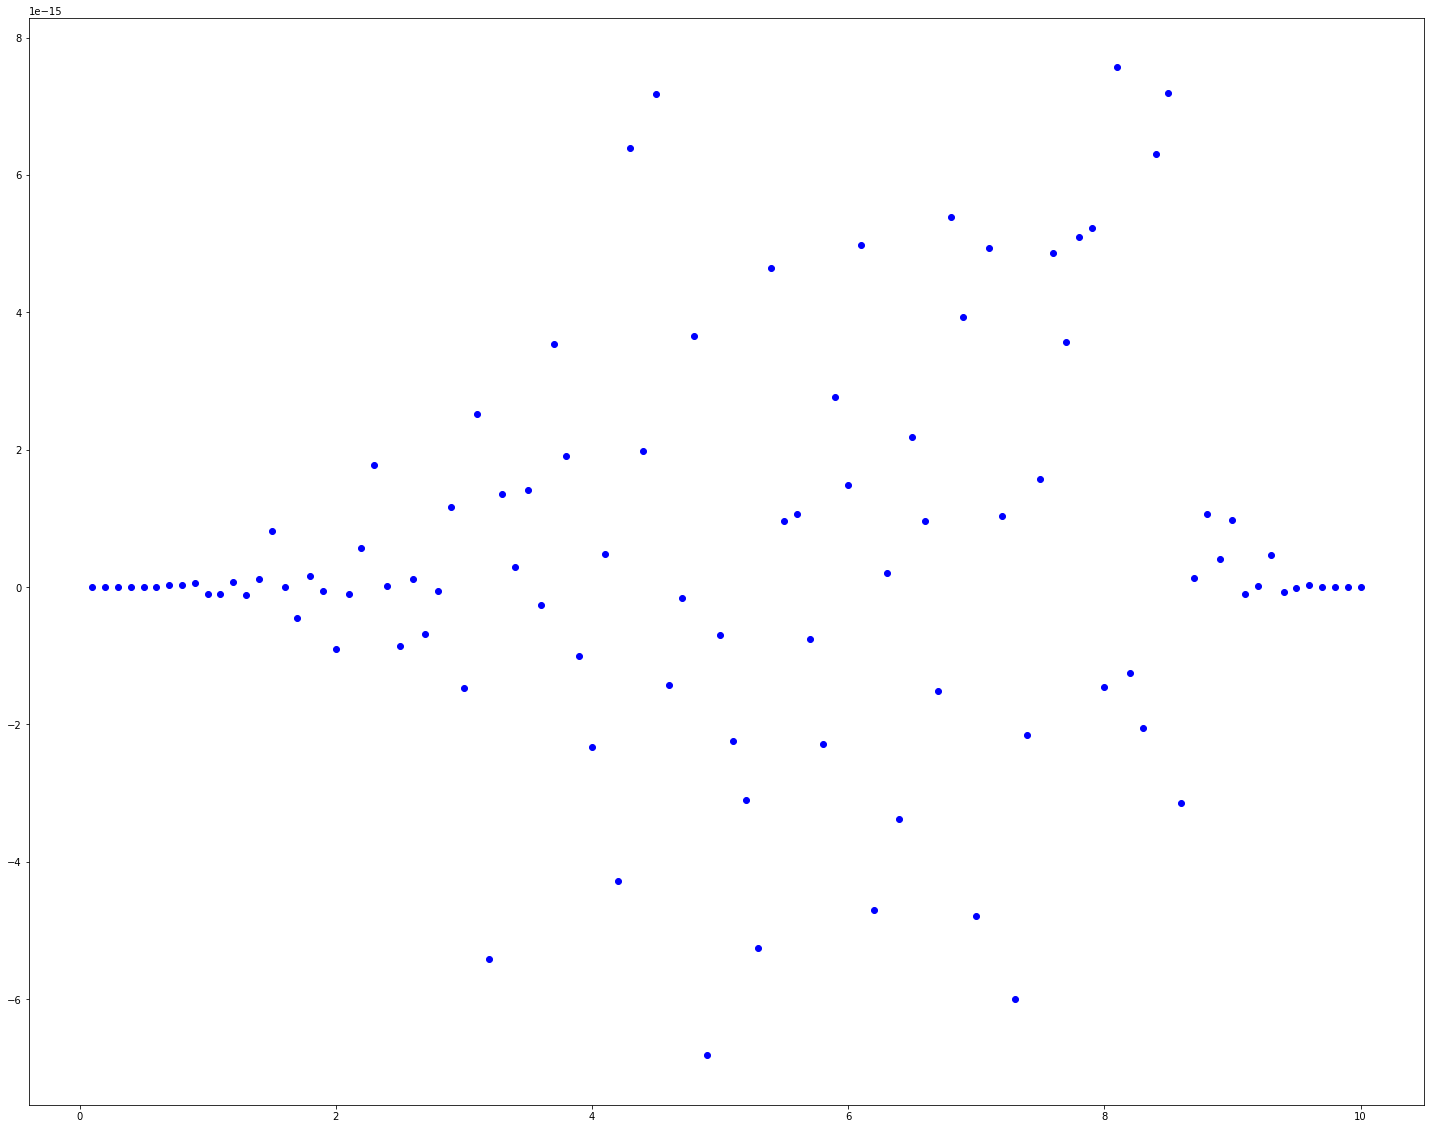

In [85]:
plt.plot(tti, Vdot0i, "bo")

In [86]:
%%time
hesse0ti = hesse0.subs(t, 10).evalf()

CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 193 ms


In [87]:
hesse0ti_eigs = npy.linalg.eig(st.to_np(hesse0ti))[0]

In [88]:
npy.real(hesse0ti_eigs)

array([ 7.50162648e+01, -7.90073165e+01,  1.39859309e+01, -1.59068925e+01, -2.15921161e+00, -4.06778876e+00,  7.30182435e-02,  6.59954628e-02, -4.00000000e+00,  5.55045920e-16])

#### V, Vdot development for simulated trajectory

In [89]:
error_traj = npy.array([err_trajp1, err_trajp2, err_trajp3, err_trajq1, err_trajq2, err_trajpdot1, err_trajpdot2, err_trajpdot3, err_trajqdot1, err_trajqdot2])

In [90]:
V_traj = []
for i in range(0, len(error_traj)):
    V_traj = 0.5 * npy.square(error_traj[i, :])

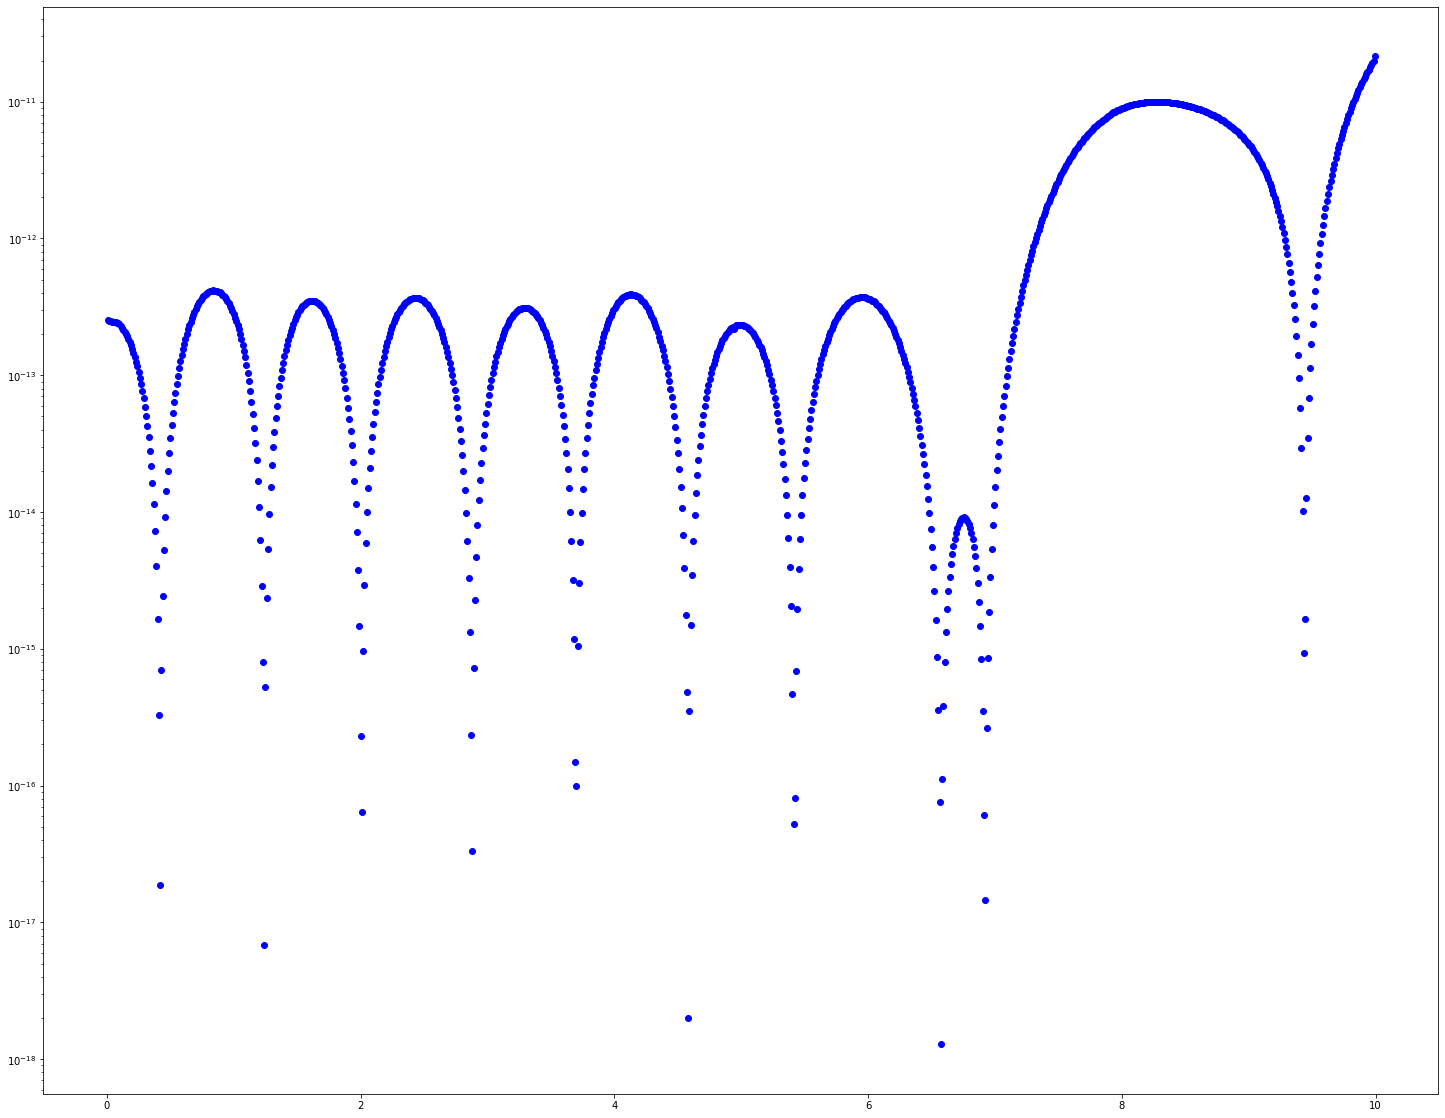

In [91]:
plt.semilogy(tt[:1000], V_traj, "bo")

In [ ]:
joint_pos_expr = st.col_stack(G1, G3, G4, G6).subs(sys_params) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = pl.figure() 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-2.3,2.3))
ax.set_aspect('equal')

line, = ax.plot([],[],'o-', lw=2)
time_template = 'time=%.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
dt = tt[1] - tt[0]


def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

l1 =1.0

def animate(i):
    xx, yy = joint_pos_func(*res[i, :res.shape[1]//2])
    
    line.set_data(xx,yy)
    time_text.set_text(time_template%(i*dt))
    
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(res.shape[0]), interval=tt[-1]*3, blit=True, init_func=init)


# this animation is nice but results in a big notebook file which is unwanted for publication in the repo
HTML(ani.to_jshtml())



